# Trajectory data

In this notebook, we will explore some trajectory data, and more advanced ways of colocating it with other data sources

In [1]:
import pathlib
from datetime import datetime
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Loading data
The data we will be using is from the International Best Track Archive for Climate Stewardship(IBTrACS). This dataset contains the trajectories of past tropical cyclones, including their location, over their lifetimes.

In [2]:
data_path = pathlib.Path("../../data_samples")

ibtracs_file = data_path / "trajectory" / "IBTrACS.NA.v04r01.nc"

assert ibtracs_file.exists, "IBTracs file not found!"

ds = xr.open_dataset(ibtracs_file)

In [3]:
ds

<xarray.Dataset> Size: 648MB
Dimensions:           (storm: 2316, date_time: 360, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 7MB ...
    lat               (storm, date_time) float32 3MB ...
    lon               (storm, date_time) float32 3MB ...
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/159)
    numobs            (storm) float32 9kB ...
    sid               (storm) |S13 30kB ...
    season            (storm) float32 9kB ...
    number            (storm) int16 5kB ...
    basin             (storm, date_time) |S2 2MB ...
    subbasin          (storm, date_time) |S2 2MB ...
    ...                ...
    reunion_gust      (storm, date_time) float32 3MB ...
    reunion_gust_per  (storm, date_time) float32 3MB ...
    usa_seahgt        (storm, date_time) float32 3MB ...
    usa_searad        (storm, date_time, quadrant) float32 13MB ...
    storm_speed       (storm, date_time) float32 3MB ...
    storm_dir         (storm, date_time) float32 3MB ...
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Oct 21 05:41:02 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

Now let's isolate a single hurricane --- hurricane Sam from 2021 --- based on its storm ID:

In [4]:
sam_sid = b"2021266N10327"
ds = ds.where(ds.sid==sam_sid, drop=True).squeeze().swap_dims(dict(date_time="time"))

The dataset also includes 360 time points to ensure all trajectories fit in the file, even though most are shorter than this. Let's also trim the trajectory to only the points with data present:

In [5]:
ds = ds.isel(time=np.isfinite(ds.time))

In [6]:
ds

<xarray.Dataset> Size: 88kB
Dimensions:           (time: 117, quadrant: 4)
Coordinates:
  * time              (time) datetime64[ns] 936B 2021-09-22T18:00:00.00003993...
    lat               (time) float32 468B ...
    lon               (time) float32 468B ...
Dimensions without coordinates: quadrant
Data variables: (12/159)
    numobs            float32 4B 117.0
    sid               object 8B b'2021266N10327'
    season            float32 4B 2.021e+03
    number            float32 4B 82.0
    basin             (time) object 936B b'NA' b'NA' b'NA' ... b'NA' b'NA' b'NA'
    subbasin          (time) object 936B b'NA' b'NA' b'NA' ... b'NA' b'NA' b'NA'
    ...                ...
    reunion_gust      (time) float32 468B nan nan nan nan ... nan nan nan nan
    reunion_gust_per  (time) float32 468B nan nan nan nan ... nan nan nan nan
    usa_seahgt        (time) float32 468B nan nan nan nan ... nan nan nan nan
    usa_searad        (time, quadrant) float32 2kB nan nan nan ... nan nan nan
    storm_speed       (time) float32 468B 12.0 13.0 14.0 16.0 ... 32.0 34.0 34.0
    storm_dir         (time) float32 468B 280.0 280.0 280.0 ... 35.0 30.0 30.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Oct 21 05:41:02 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

## Plotting a trajectory

Now let's plot the trajectory on a map:

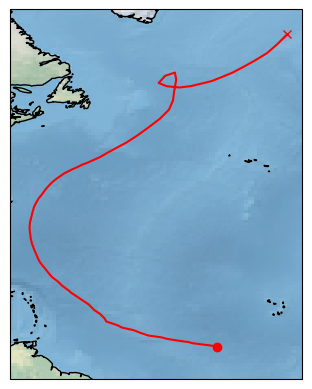

In [7]:
fig, ax = plt.subplots(1,1,subplot_kw=dict(projection=ccrs.PlateCarree()))

ax.plot(ds.lon, ds.lat, "r-", transform=ccrs.Geodetic())
ax.plot(ds.lon[0], ds.lat[0], "ro", transform=ccrs.Geodetic())
ax.plot(ds.lon[-1], ds.lat[-1], "rx", transform=ccrs.Geodetic())
ax.coastlines()
ax.background_img()
ax.set_extent([-65, -20, 5, 60])

The trajectory is not only a series of points in space, but also in time. We need to take this into account when comparing to other data!

## Colocating data with the trajectory:
Now let's look into colocating the trajectory with another source of data. The easiest way to do this is using xarray's nearest neighbour search:

In [8]:
# Load some ERA-5 data from the cloud:
era5 = xr.open_zarr(
    'gs://gcp-public-data-arco-era5/ar/full_37-1h-0p25deg-chunk-1.zarr-v3',
    chunks=None,
    storage_options=dict(token='anon'),
)

In [9]:
era5

<xarray.Dataset> Size: 4PB
Dimensions:                                                          (
                                                                      time: 1323648,
                                                                      latitude: 721,
                                                                      longitude: 1440,
                                                                      level: 37)
Coordinates:
  * latitude                                                         (latitude) float32 3kB ...
  * level                                                            (level) int64 296B ...
  * longitude                                                        (longitude) float32 6kB ...
  * time                                                             (time) datetime64[ns] 11MB ...
Data variables: (12/273)
    100m_u_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    100m_v_component_of_wind                                         (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_u_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_neutral_wind                                  (time, latitude, longitude) float32 5TB ...
    10m_v_component_of_wind                                          (time, latitude, longitude) float32 5TB ...
    ...                                                               ...
    wave_spectral_directional_width_for_swell                        (time, latitude, longitude) float32 5TB ...
    wave_spectral_directional_width_for_wind_waves                   (time, latitude, longitude) float32 5TB ...
    wave_spectral_kurtosis                                           (time, latitude, longitude) float32 5TB ...
    wave_spectral_peakedness                                         (time, latitude, longitude) float32 5TB ...
    wave_spectral_skewness                                           (time, latitude, longitude) float32 5TB ...
    zero_degree_level                                                (time, latitude, longitude) float32 5TB ...
Attributes:
    valid_time_start:       1940-01-01
    last_updated:           2025-10-23 02:22:34.355593+00:00
    valid_time_stop:        2025-04-30
    valid_time_stop_era5t:  2025-10-17

In [10]:
sst = era5.sea_surface_temperature

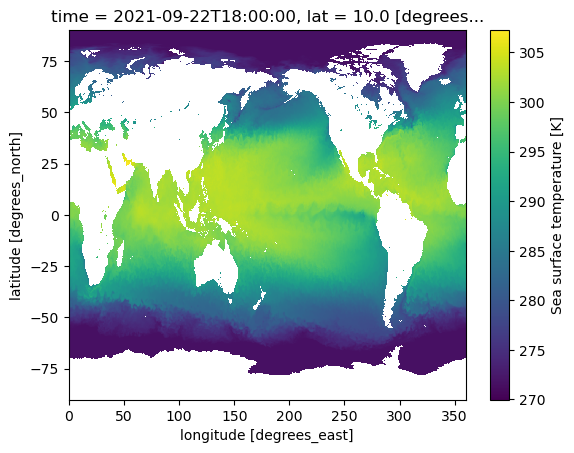

In [11]:
sst.sel(time=ds.time[0],method="nearest").plot()

In [12]:
sst

<xarray.DataArray 'sea_surface_temperature' (time: 1323648, latitude: 721,
                                             longitude: 1440)> Size: 5TB
[1374264299520 values with dtype=float32]
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 11MB 1900-01-01 ... 2050-12-31T23:00:00
Attributes:
    long_name:   Sea surface temperature
    short_name:  sst
    units:       K

In [13]:
# Now let's index using the lat, lon and time from the hurricane trajectory:
sam_sst = sst.sel(time=ds.time, latitude=ds.lat%360, longitude=ds.lon%360, method="nearest")

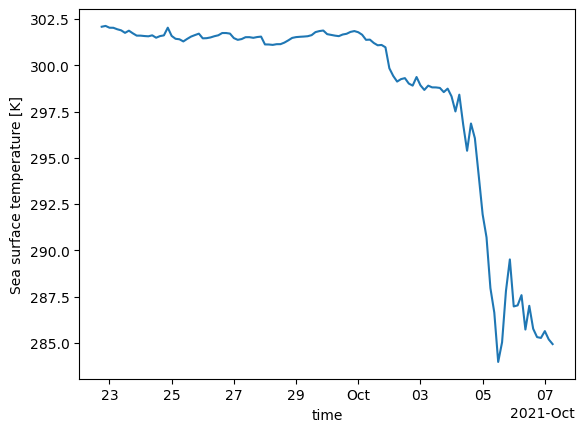

In [14]:
sam_sst.plot()

Nearest neighbour interpolation is simple and quick, but what if we want something a bit more precise? xarray can also be used to interpolate the values at each point along the trajectory:

In [15]:
sam_sst_interp = sst.interp(
    coords=dict(time=ds.time, latitude=ds.lat%360, longitude=ds.lon%360), 
    method="linear"
)

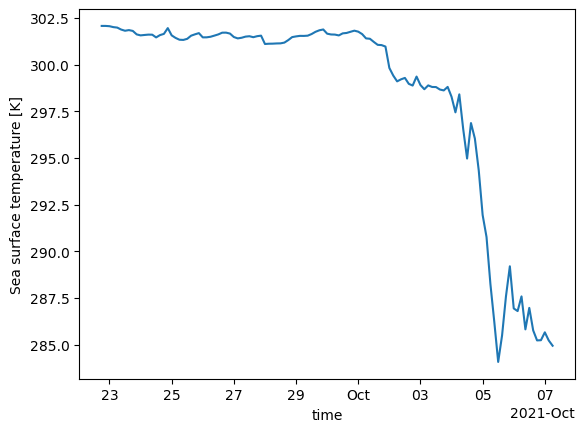

In [16]:
sam_sst_interp.plot()

This is slower as it needs to load more data, but can be more accurate depending on the use case and the resolution of the data being colocated to the trajectory (generally lower resolution data benefits more from interpolation)

## Advanced colocation
But what if we wanted to colocate some data that isn't on a nice rectilinear grid (e.g. the MODIS data from the satellite notebook), or what if we want more than just a single point? For more advanced colocation, we can use a useful tool provided by the `scikit-learn` library:

To colocate the nearest measurements, we can use a `BallTree`, which is an efficient data structure for finding nearest neighbours

In [17]:
# First create a BallTree using the ERA5 latitude and longitude pairs
from sklearn.neighbors import BallTree
btree = BallTree(
    np.radians( # Note that we need to convert lat/lon to radians for the Haversine distance to work correctly
        np.stack(np.meshgrid(sst.latitude, sst.longitude, indexing="ij"), -1).reshape(-1,2) # BallTree needs 1d arrays for each coordinate, so reshape
    ), 
    metric = "haversine",
)

The advantage of the BallTree is that we only have to compute it once, and then finding points from it is easy and fast.

The main method to find nearest neighbours is using the `.query` method, which finds the `k` nearest neighbours (default 1). We can pass multiple points to this and find the indexes of each ones neighbours:

In [18]:
# Now query the BallTree for the nearest neighbour to each Cloudsat lat/lon pair:
distances, indexes = btree.query(
    np.radians(np.stack([ds.lat, ds.lon], -1)), 
)

This returns an array of the 1D indexes of the nearest points, and an array of the distances (in radians) between the trajectory points and the nearest era5 points

#### Exercise:
Convert the 1D indexes back into 2D indexes using the `np.unravel_index` function. Find the EAR5 latitude and longitude of each of these points using these new indexes. Do these match the latitude and longitudes that `xarray` returned for the nearest neighbours?

In [19]:
lat_id, lon_id = np.unravel_index(indexes.ravel(), (sst.latitude.size, sst.longitude.size))

In [20]:
lat_id, lon_id

(array([320, 320, 319, 319, 318, 318, 317, 317, 316, 316, 316, 315, 314,
        314, 314, 313, 312, 312, 311, 310, 310, 309, 309, 308, 308, 307,
        306, 306, 306, 305, 305, 304, 304, 303, 302, 301, 300, 299, 298,
        298, 296, 295, 294, 293, 292, 292, 291, 290, 289, 288, 288, 287,
        286, 285, 284, 282, 281, 280, 279, 278, 276, 274, 272, 270, 268,
        266, 263, 260, 257, 254, 250, 247, 243, 240, 237, 234, 232, 229,
        226, 224, 221, 219, 217, 215, 213, 212, 211, 210, 208, 207, 205,
        203, 200, 198, 194, 190, 185, 180, 174, 168, 162, 156, 151, 153,
        158, 160, 160, 160, 158, 156, 154, 151, 148, 144, 139, 134, 128]),
 array([1308, 1305, 1302, 1299, 1296, 1293, 1290, 1287, 1284, 1281, 1279,
        1276, 1274, 1271, 1268, 1265, 1263, 1260, 1258, 1256, 1255, 1253,
        1251, 1249, 1248, 1246, 1245, 1244, 1242, 1241, 1240, 1239, 1239,
        1238, 1238, 1237, 1236, 1234, 1233, 1232, 1231, 1230, 1228, 1227,
        1226, 1225, 1224, 1222, 1221, 1220, 1

In [21]:
np.all(sst.latitude[lat_id] == sam_sst.latitude.values)

<xarray.DataArray 'latitude' ()> Size: 1B
array(True)

In [22]:
np.all(sst.longitude[lon_id] == sam_sst.longitude.values)

<xarray.DataArray 'longitude' ()> Size: 1B
array(True)

Alternatively to finding a fixed number of neighbours, you can also use the BallTree to find all points within a certain distance using the `.query_radius` method.

#### Exercise:
Find the point at which Hurricane Sam reached its fastest wind speeds. Then, find all the SST values within 1000km of this point. Finally, use `xarray`'s `groupby_bins` function to see how the average SST varies with distance from the hurricane centre.

Tips:
  - use `.idxmax` to find the coordindates of a dataarray at its max value
  - convert distance to radians by dividing the distance by the radius of the Earth, convert radians to distance by multiplying by the Earth radius
  - use the keyword `return_distance=True` with `query_radius` to get distances as well as indexes, note that the arrays returned will be length one arrays containing the arrays for the queried point, so make sure to select the 0th item

In [23]:
ds.sel(time=ds.wmo_wind.idxmax())

<xarray.Dataset> Size: 912B
Dimensions:           (quadrant: 4)
Coordinates:
    time              datetime64[ns] 8B 2021-09-26T18:00:00.000039936
    lat               float32 4B 14.1
    lon               float32 4B -50.3
Dimensions without coordinates: quadrant
Data variables: (12/159)
    numobs            float32 4B 117.0
    sid               object 8B b'2021266N10327'
    season            float32 4B 2.021e+03
    number            float32 4B 82.0
    basin             object 8B b'NA'
    subbasin          object 8B b'NA'
    ...                ...
    reunion_gust      float32 4B nan
    reunion_gust_per  float32 4B nan
    usa_seahgt        float32 4B 12.0
    usa_searad        (quadrant) float32 16B 150.0 90.0 90.0 120.0
    storm_speed       float32 4B 4.0
    storm_dir         float32 4B 325.0
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue Oct 21 05:41:02 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

In [24]:
indexes, distances = btree.query_radius(
    np.radians(np.stack([ds.sel(time=ds.wmo_wind.idxmax()).lat, ds.sel(time=ds.wmo_wind.idxmax()).lon], -1)).reshape(1,2), 
    1000/6371, 
    return_distance=True, 
)
indexes = indexes[0]
distances = distances[0]

In [25]:
sst_distances = xr.DataArray(
    sst.sel(time=ds.wmo_wind.idxmax(), method="nearest").values.ravel()[indexes.ravel()], 
    dims=("distance"), 
    coords=dict(distance=distances*6371)
)

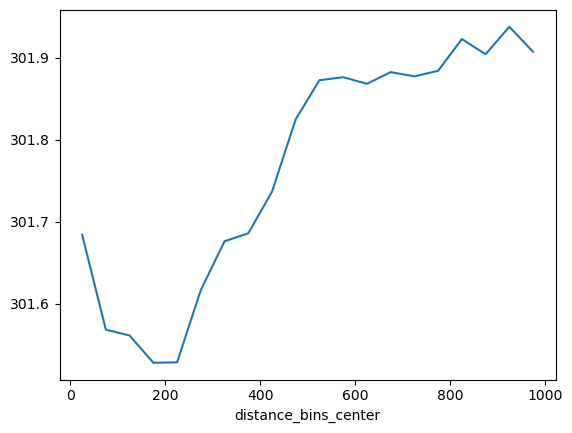

In [26]:
sst_distances.groupby_bins("distance", np.linspace(0,1000,21)).mean().plot()